In [1]:
# Import packages.
import queue, random, threading, math, time, pickle, psutil
import Adjustable_Snake as snake    # Snake game.
import tensorflow as tf             # Tensorflow.
import numpy as np                  # I chose NumPy instead of Pandas because it uses less RAM.
import tkinter as tkinter           # Required to control the game.
import matplotlib.pyplot as plt     # Plotting statistics.

# This code allows for the GPU to be utilized properly.
tf.autograph.set_verbosity(0)
physical_devices = tf.config.list_physical_devices("GPU")
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    pass

print(physical_devices)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
# Save directory, includes model and replay memory.
save_path = "./save"


# Hyperparameters below control the training of the agent.

stack_size = 2  # Phi; amount of frames the agent sees e.g. stack_size 4 means the agent sees the 
                # last 4 frames.

game_size = 15  # The dimensions of the game (it is square).


explore_count = 20000      # The epsilon-greedy slope stops changing after this many episodes.
start_epsilon = 1           # The epsilon slope begins at this float. 
end_epsilon = 0.05          # The epsilon slope stops at this float. 


discount = 0.99         # Discount factor. A higher discount factor determines how much the agent
                        # should care about prioritizing the future vs. the present.

learning_rate = 0.001   # AKA step size.

c = 1000                # The target Q-network (Q-hat) is reset to the behaviour Q-net after this
                        # many frames.


memory_size = 50000 # The size of the replay memory.

batch_size = 64     # The mini-batch size used for a gradient descent step.

In [3]:
def make_model():
    '''Creates a tf.keras.Sequential model with numerous hidden layers.'''
    q = tf.keras.Sequential()

    input_size = (game_size * game_size * stack_size,)  # The input tensor to the model.
    neuron_count = (input_size[0] + 5) / 4

    # The network. Hidden layers were determined with this source: 
    # https://stats.stackexchange.com/questions/181/how-to-choose-the-number-of-hidden-layers-and-nodes-in-a-feedforward-neural-netw
    q.add(tf.keras.layers.Dense(units=neuron_count, input_shape=input_size, activation="relu"))
    q.add(tf.keras.layers.Dense(5)) # 5 outputs for 5 different actions.

    q.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss="mse")

    return q

In [4]:
try:
    # Try to load a saved model.
    q1 = tf.keras.models.load_model(save_path + "/model1")
    target_q = tf.keras.models.load_model(save_path + "/target_q")

    print("Loaded models")
except Exception as e:
    # Create a model if no save exists.
    print(e)
    q1 = make_model()
    target_q = make_model()
    print("Created model")

q1.summary()
target_q.summary()

Loaded models
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 113)               50963     
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 570       
Total params: 51,533
Trainable params: 51,533
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 113)               50963     
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 570       
Total params: 51,533
Trainable params: 51,533
Non-trainable params: 0
_________________________________________________________________


In [5]:
try:
    # Try to load replay memory and statistics.
    with open(save_path + "/update_index.dat", "rb") as openfile:
        update_index = int(pickle.load(openfile))
    with open(save_path + "/filled_memory.dat", "rb") as openfile:
        filled_memory = int(pickle.load(openfile))
    with open(save_path + "/reset_steps.dat", "rb") as openfile:
        reset_steps = int(pickle.load(openfile))

    # Replay memory isn't stored using Pickle because it uses too much RAM.
    states_memory = np.load(save_path + "/states_memory.npy")
    action_memory = np.load(save_path + "/action_memory.npy")
    reward_memory = np.load(save_path + "/reward_memory.npy")
    transitions_memory = np.load(save_path + "/transitions_memory.npy")

    # Statistics.
    with open(save_path + "/scores.dat", "rb") as openfile:
        scores = pickle.load(openfile)

    print("Loaded replay memory")
except Exception as e:
    # Create the replay memory if non-existent.
    print(e)
    update_index = 0    # Which index of the replay memory to update.
    filled_memory = 0   # The amount of experiences in the memory.
    reset_steps = 0     # The amount of frames that have passed since the last target_q reset.s

    # Replay Memory.
    states_memory = np.ndarray((memory_size, game_size * game_size * stack_size))
    action_memory = np.ndarray((memory_size))
    reward_memory = np.ndarray((memory_size))
    transitions_memory = np.ndarray((memory_size, game_size * game_size * stack_size))

    # Stats.
    scores = [0]
    
    print("Created replay memory")

Loaded replay memory


In [6]:
class agent:
    '''This creates an agent that plays and learns snake. All of the functions
       used for training are contained in this class.'''

    # The possible actions that the agent can take each frame.
    directions = ["UP", "DOWN", "LEFT", "RIGHT", "NONE"]


    def __init__(self, game):
        '''Sets the game window for the agent to control, and initializes the frame stack (phi).
        
           Function Parameters:
           game <snake.game> = the game window that the agent will use as its environment'''
        self.game = game
        self.phi = queue.deque()


    def update_memory(self, states, action, reward, transitions):
        '''Creates a new experience in the replay memory. Each experience is stored between 4
           seperate NumPy arrays, at the same index.

           Function Parameters:
           states <np.ndarray; shape=(game_size^2 * stack_size)> = the state/frame stack for the experience
           action <int> = the action taken
           reward <int> = the reward received for taking said action in state
           transitions <np.ndarray; shape=(game_size^2 * stack_size)> = the frame stack of the frame AFTER taking said action'''

        global update_index, filled_memory
        # Start replacing experiences in the memory from the beginning again.
        if update_index >= memory_size:
            update_index = 0

        # Insert the experience into replay memory.
        states_memory[update_index] = states
        action_memory[update_index] = action
        reward_memory[update_index] = reward
        transitions_memory[update_index] = transitions

        update_index += 1
        # Keep track of how much of the memory has been filled.
        if filled_memory < memory_size:
            filled_memory += 1


    def stack(self, frames):
        '''Formats a frame stack (phi) to be inputtable to the model.

           Function Parameters:
           frames <np.ndarray; shape=(game_size, game_size, stack_size)> = the frame stack to convert to a single input tensor'''

        # This code is for when I need input to an RGB convolutional model with Conv3D.
        # 
        # fstack = np.stack(frames, axis=2)

        # This code is for when I need input to a black/white convolutional model with Conv2D.
        # 
        # fstack = frames[0]
        # for x in range(1, len(frames)):
        #     frame = np.expand_dims(frames[x], axis=2)
        #     print(fstack.shape)
        #     print(frame.shape)
        #     # frame = frames[x]
        #     fstack = np.stack((fstack, frame), axis=2)
            
        # This code takes the frame stack and lays it out into a 1-D tensor.
        fstack = np.array([])
        for state in frames: # Iterate through each frame.
            for i in state:  # Iterate through and append each row in a the current frame.
                fstack = np.append(fstack, i)

        return fstack


    def epsilon_action(self):
        '''The epsilon-greedy policy decides whether the agent will
           choose the action it thinks is best, or choose a random
           action. Currently, there is an epsilon slope, where the
           agent will take less random actions the better it performs.'''

        # Call np.expand_dims so that it can be used as input to the model.
        stack = np.expand_dims(self.stack(self.phi), axis=0)

        # Calculate the percentage of episodes played in relation to explore_count, and
        # cap it at 100% (stored as 1.0f in code).
        explore_count_percent = len(scores) / explore_count
        if explore_count_percent > 1:
            explore_count_percent = 1

        # Calculate what the current epsilon balue should be. The epsilon decreases from 
        # start_epsilon to end_epsilon over explore_count episodes.
        current_epsilon = start_epsilon - ((start_epsilon - end_epsilon) * explore_count_percent)

        # If a uniformly drawn random float is less than or equal the current epsilon,
        # take a random action.
        if random.uniform(0, 1) <= current_epsilon:
            prediction = [["n/a", "n/a", "n/a", "n/a", "n/a"]]

            action = self.directions[random.randint(0, 4)]
        else:
            # Select the best action, according to the model.
            prediction = q1.predict(stack)

            maxq = np.argmax(prediction)
            action = self.directions[maxq]
        return action, prediction


    def step(self):
        '''Advances the game by one frame. It is called by the game, and passes an action to
           the game when it advances a frame.'''

        # Initialize phi entirely with starting frames.
        if len(self.phi) == 0:
            for x in range(stack_size):
                self.phi.append(self.game.get_state())

        # Get action according to epsilon-greedy policy, and the Q-values
        # for all actions (debug purposes).
        action, values = self.epsilon_action()

        # Step the game forward one frame, and receive the next state and the reward.
        state_reward = self.game.step(action, values)

        phi_last = list(self.phi)
        self.phi.append(state_reward[0])  # Update the frame stack with the latest frame.

        # Update replay memory when there are enough frames in the frame stack.
        if len(self.phi) > stack_size:
            phi_last = self.stack(phi_last)
            self.phi.popleft()
            phi_current = self.stack(self.phi)

            # Update the memory with the last state, the action taken in the last state, the reward for doing so, 
            # and the resulting state.
            self.update_memory(phi_last, self.directions.index(action), state_reward[1], phi_current)


    def get_batch_indices(self):
        '''Gets a list of experiences from the replay memory. In reality,
           returns a list of indexes that are used to access the parts of  
           each experience in each array.'''

        indices = []
        for x in range(batch_size):
            indices.append(random.randint(0, filled_memory - 1))

        return indices


    def learn(self):
        '''This function is also called by the game mainloop, once self.step() has been called.
           As the name suggests, it performs a gradient descent step, and also resets the
           target Q-network if needed.'''

        global reset_steps, c

        pred_tensor = np.ndarray((batch_size))
        real_tensor = np.ndarray((batch_size))

        # Create the mini-batch of experiences.
        indices = self.get_batch_indices()
        states = states_memory[indices]
        actions = action_memory[indices]
        rewards = reward_memory[indices]
        transitions = transitions_memory[indices]
        dones = []

        for t in range(batch_size):
            if rewards[t] < 0:
                dones.append(1.0)
            else:
                dones.append(0.0)
        dones = tf.convert_to_tensor(dones)

        # ================================================================================ #
        # ALL OF THIS IS COPIED FROM https://keras.io/examples/rl/deep_q_network_breakout/
        # AND I HAVE NO IDEA WHAT IT DOES

        q_phi_next = target_q.predict(transitions)

        target_q_values = discount * tf.reduce_max(q_phi_next, axis=1)
        target_q_values = rewards + target_q_values * (1 - dones)

        masks = tf.one_hot(actions, 5)

        with tf.GradientTape() as tape:
            q_phi = q1(states)
            q_action = tf.reduce_sum(tf.multiply(q_phi, masks), axis=1)
            loss = tf.keras.losses.mean_squared_error(target_q_values, q_action)

        gradients = tape.gradient(loss, q1.trainable_variables)
        q1.optimizer.apply_gradients(zip(gradients, q1.trainable_variables))

        # ================================================================================ #

        # If the learning rate is too large and causes the model to diverge to infinity, let the user know.
        after1 = q1.predict(np.expand_dims(self.stack(self.phi), axis=0))
        if math.isnan(after1[0][0]):
            print("NaN")
        if math.isinf(after1[0][0]):
            print("inf")

        reset_steps += 1
        if reset_steps >= c:
            # Reset the target Q-network to the behaviour Q-network.
            reset_steps = 0
            target_q.set_weights(q1.get_weights())
            # ^^^ There might be some issues with this. For one, the name get_weights() suggests
            # that only the weights of the target Q-network will be set, and not the biases. As
            # far as I currently know, there aren't any other ways to create deep copies of tf 
            # models, so this might need some changing.

In [7]:
def plot():
    '''Plot statistics.'''
    
    print("SCORE v. EPISODE")
    plt.plot(scores)
    plt.xlabel("Episode")
    plt.ylabel("Score")
    plt.show()
    print("==============================")

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: ./save/model1\assets
INFO:tensorflow:Assets written to: ./save/target_q\assets
SCORE v. EPISODE


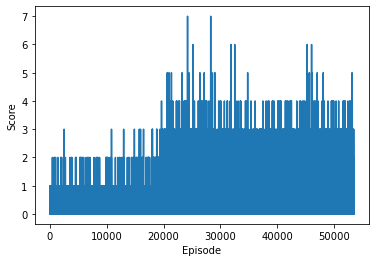

INFO:tensorflow:Assets written to: ./save/model1\assets
INFO:tensorflow:Assets written to: ./save/target_q\assets
SCORE v. EPISODE


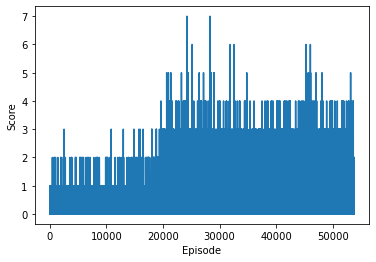

INFO:tensorflow:Assets written to: ./save/model1\assets
INFO:tensorflow:Assets written to: ./save/target_q\assets
SCORE v. EPISODE


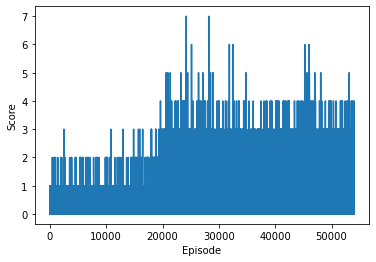

INFO:tensorflow:Assets written to: ./save/model1\assets
INFO:tensorflow:Assets written to: ./save/target_q\assets
SCORE v. EPISODE


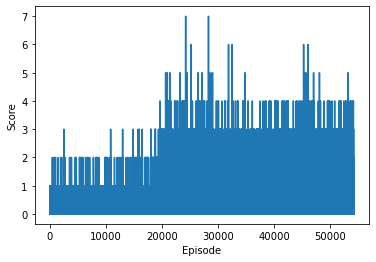

INFO:tensorflow:Assets written to: ./save/model1\assets
INFO:tensorflow:Assets written to: ./save/target_q\assets
SCORE v. EPISODE


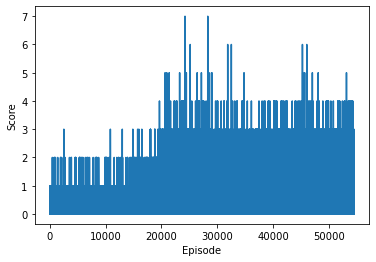

INFO:tensorflow:Assets written to: ./save/model1\assets
INFO:tensorflow:Assets written to: ./save/target_q\assets
SCORE v. EPISODE


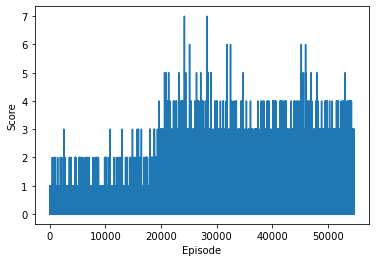

INFO:tensorflow:Assets written to: ./save/model1\assets
INFO:tensorflow:Assets written to: ./save/target_q\assets
SCORE v. EPISODE


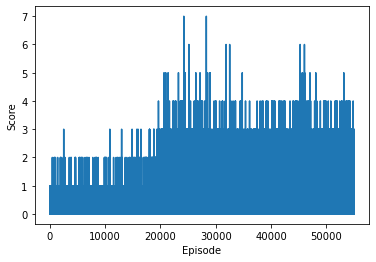

INFO:tensorflow:Assets written to: ./save/model1\assets
INFO:tensorflow:Assets written to: ./save/target_q\assets
SCORE v. EPISODE


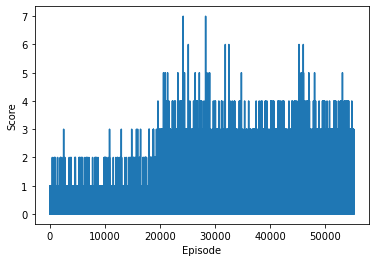

INFO:tensorflow:Assets written to: ./save/model1\assets
INFO:tensorflow:Assets written to: ./save/target_q\assets
SCORE v. EPISODE


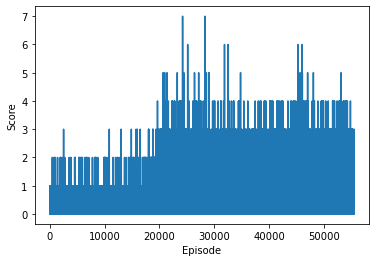

INFO:tensorflow:Assets written to: ./save/model1\assets
INFO:tensorflow:Assets written to: ./save/target_q\assets
SCORE v. EPISODE


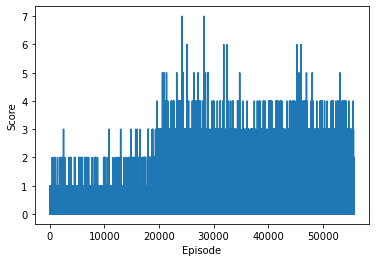

INFO:tensorflow:Assets written to: ./save/model1\assets
INFO:tensorflow:Assets written to: ./save/target_q\assets
SCORE v. EPISODE


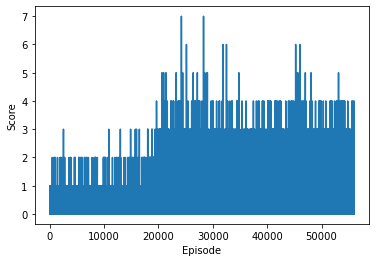

INFO:tensorflow:Assets written to: ./save/model1\assets
INFO:tensorflow:Assets written to: ./save/target_q\assets
SCORE v. EPISODE


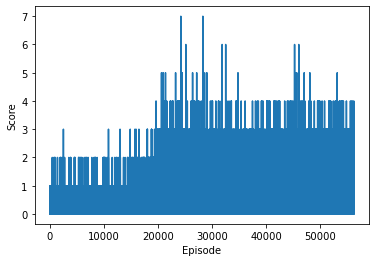

INFO:tensorflow:Assets written to: ./save/model1\assets
INFO:tensorflow:Assets written to: ./save/target_q\assets
SCORE v. EPISODE


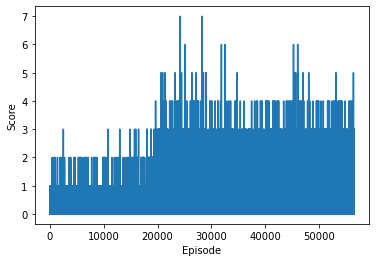

INFO:tensorflow:Assets written to: ./save/model1\assets
INFO:tensorflow:Assets written to: ./save/target_q\assets
SCORE v. EPISODE


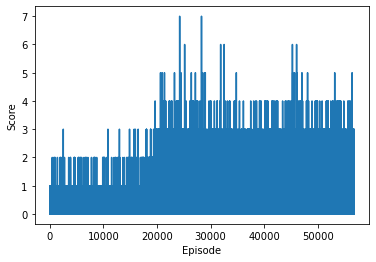

INFO:tensorflow:Assets written to: ./save/model1\assets
INFO:tensorflow:Assets written to: ./save/target_q\assets
SCORE v. EPISODE


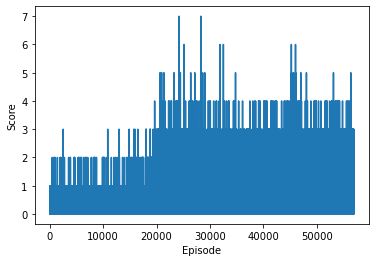

INFO:tensorflow:Assets written to: ./save/model1\assets
INFO:tensorflow:Assets written to: ./save/target_q\assets
SCORE v. EPISODE


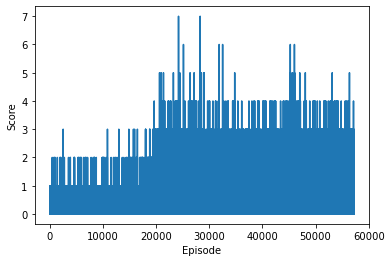

INFO:tensorflow:Assets written to: ./save/model1\assets
INFO:tensorflow:Assets written to: ./save/target_q\assets
SCORE v. EPISODE


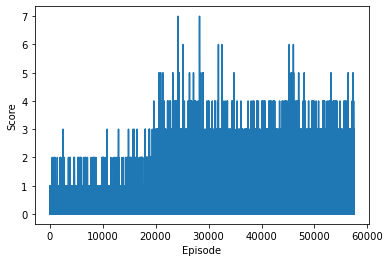

INFO:tensorflow:Assets written to: ./save/model1\assets
INFO:tensorflow:Assets written to: ./save/target_q\assets
SCORE v. EPISODE


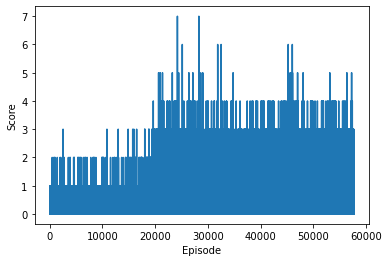

INFO:tensorflow:Assets written to: ./save/model1\assets
INFO:tensorflow:Assets written to: ./save/target_q\assets
SCORE v. EPISODE


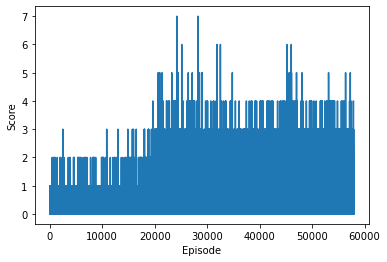

In [8]:
game = snake.game()
x = 0

while True:
    dqn = agent(game)

    game.start(dqn)

    if x % 250 == 0:
        # Save the models every n episodes.
        q1.save(save_path + "/model1", overwrite=True, include_optimizer=True)
        target_q.save(save_path + "/target_q", overwrite=True, include_optimizer=True)

    if x % 250 == 0:
        # Save the replay memory and statistics every n episodes.
        with open(save_path + "/update_index.dat", "wb") as openfile:
            pickle.dump(update_index, openfile)
        with open(save_path + "/reset_steps.dat", "wb") as openfile:
            pickle.dump(reset_steps, openfile)
        with open(save_path + "/filled_memory.dat", "wb") as openfile:
            pickle.dump(filled_memory, openfile)

        np.save(save_path + "/states_memory", states_memory)
        np.save(save_path + "/action_memory", action_memory)
        np.save(save_path + "/reward_memory", reward_memory)
        np.save(save_path + "/transitions_memory", transitions_memory)

        with open(save_path + "/scores.dat", "wb") as openfile:
            pickle.dump(scores, openfile)

        plot()
    x += 1

    # Trackthe score/performance of the agent.
    scores.append(game.score)